In [1]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
project_dir='/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[(GoodSubs['FD_exclusion']<=2)&(GoodSubs['ABS_exclusion']<=2)&(GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)


HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
print(" There are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                         len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))

We collected and downloaded data from 43 subjects
 There are 34 number of subjects who passed the exclusion criteria.
 19 Were collected using a 64 channel headcoil and 15 with a 20 channel headcoil


## Compute TSNR if Not Already

In [3]:
prep_dir='%s/derivatives/fmriprep'%(project_dir)
f_list = [prep_dir+'/%s/func/%s_task-sharedreward_acq-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'%(row['sub']                                                                                            ,row['sub'],
                                                                                                    row['acq']) for index,row in subs.iterrows()]
from nilearn.image import math_img

for img in tqdm(f_list):  

    me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
    mb=int(re.search('_acq-mb(.*?)me',img).group(1))
    sub=re.search('func/sub-(.*?)_task',img).group(1)

    if not os.path.exists('../derivatives/tsnr/sub-%s_acq-mb%sme%s_tsnr.nii.gz' %(sub,mb,me)):
        print('sub: %s Multiband: %s Multiecho: %s'%(sub,mb,me))
        print('does not exist')
        mask = '../derivatives/fmriprep/sub-%s/func/sub-%s_task-sharedreward_acq-mb%sme%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%(sub,sub,mb,me)

        nifti_masker = NiftiMasker(mask_img=mask)
        x=nifti_masker.fit_transform(img)
        img=nifti_masker.inverse_transform(x)
        tsnr_img = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=img)
        tsnr_img.to_filename('../derivatives/tsnr/sub-%s_acq-mb%sme%s_tsnr.nii.gz' %(sub,mb,me))


100%|███████████████████████████████████████| 202/202 [00:00<00:00, 3297.55it/s]


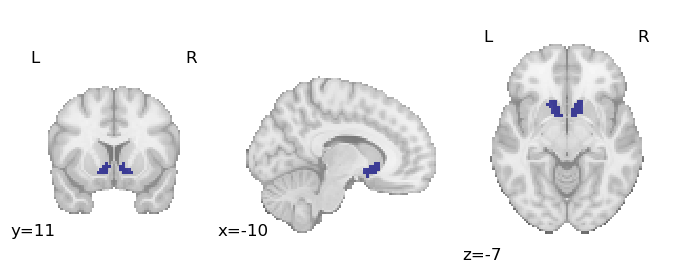

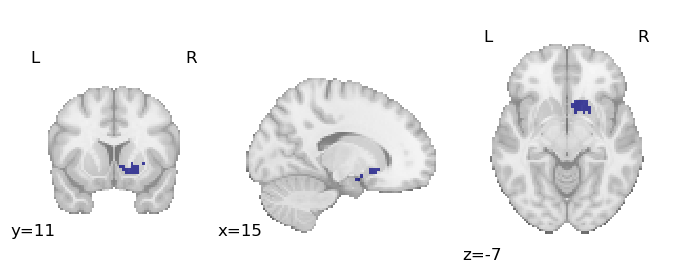

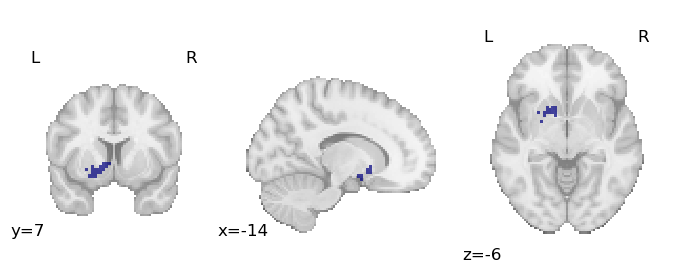

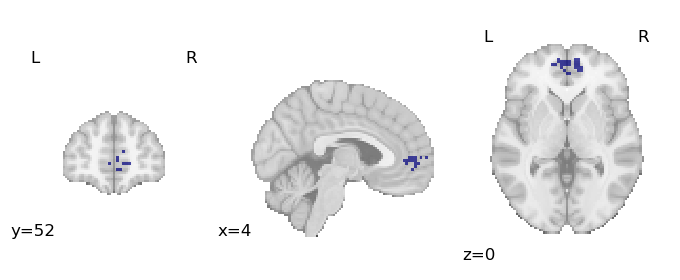

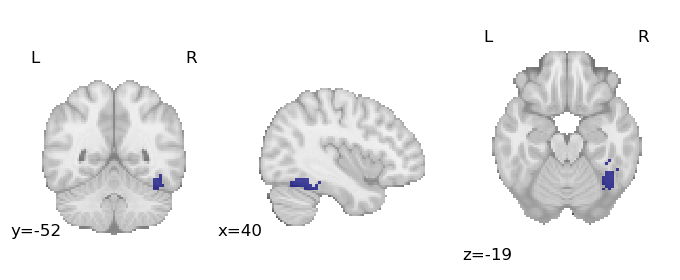

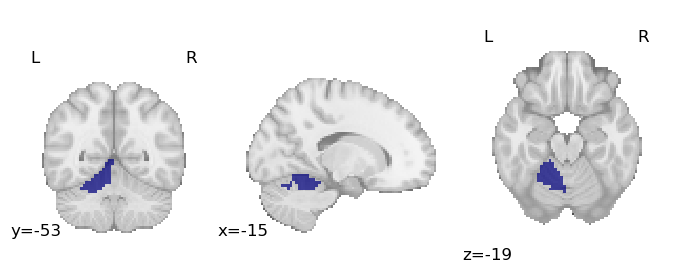

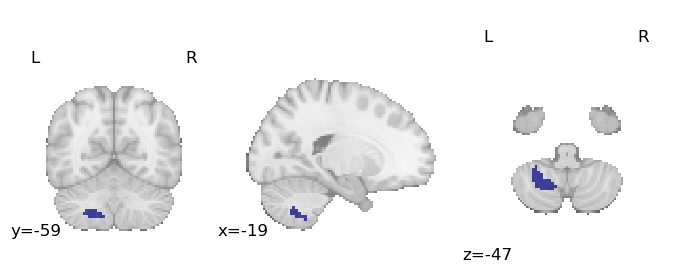

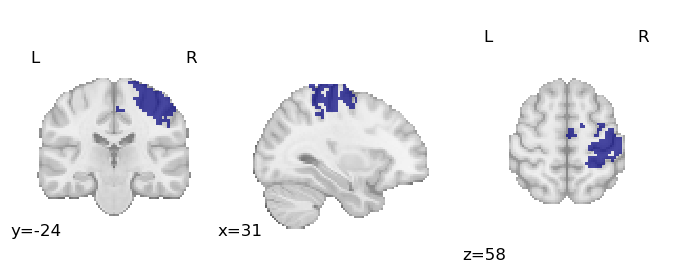

In [4]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/fROI-FFA_cname-StrVsComp_zstat-1.nii.gz'
    sCerb_mask='../masks/fROI-sCerb_cname-LeftVsRight_zstat-1.nii.gz'
    iCerb_mask='../masks/fROI-iCerb_cname-LeftVsRight_zstat-1.nii.gz'
    motor_mask='../masks/fROI-Motor_cname-LeftVsRight_zstat-1.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        plotting.plot_roi(mask,draw_cross=False)
        plt.show()

In [5]:
flist=['../derivatives/tsnr/%s_acq-%s_tsnr.nii.gz'%(row['sub'],row['acq']) for index,row in subs.iterrows()]
#display(flist)
data=[]
img_list=[]
if os.path.exists("../derivatives/TSNRinfo.tsv"):
    df=pd.read_csv("../derivatives/TSNRinfo.tsv",sep='\t')
else:
    for img in tqdm(flist):
        start = time.time()
        tsnr_img=img
        #print(img)
        sub=re.search('tsnr/sub-(.*?)_acq',img).group(1)
        me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
        mb=int(re.search('_acq-mb(.*?)me',img).group(1))
        #sub=re.search('func/sub-(.*?)_task',img).group(1)
        #print('sub: %s Multiband: %s Multiecho: %s'%(sub,mb,me))
        #tsnr_img = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=img)

        for mask in mask_list:
            nifti_masker = NiftiMasker(mask_img=mask)
            mask_name=re.search('ROI-(.*)_cname',mask).group(1)
            x=nifti_masker.fit_transform(tsnr_img)
            img=nifti_masker.inverse_transform(x)
            data.append([sub,mb,me,mask_name,np.mean(x.flatten())])
    df=pd.DataFrame(data=data,columns=['sub','MB','ME','Region','TSNR'])
    df.to_csv("../derivatives/TSNRinfo.tsv",sep="\t",index=False)
df['sub']='sub-'+df['sub'].astype(str)

In [6]:
#df=pd.read_csv("../derivatives/TSNRinfo.tsv",sep='\t')
df['acq']='mb'+df['MB'].astype(str)+'me'+df['ME'].astype(str)
#df['sub']='sub-'+df['sub'].astype(str)
display(df.head())
display(subs.head())
df2 = pd.merge(df, subs, on=["sub","acq"])
df2

,sub,MB,ME,Region,TSNR,acq
0,sub-10017,6,4,VS,31.702188,mb6me4
1,sub-10017,6,4,RVS,28.980915,mb6me4
2,sub-10017,6,4,LVS,26.821964,mb6me4
3,sub-10017,6,4,vmPFC,40.178303,mb6me4
4,sub-10017,6,4,FFA,50.127300,mb6me4


,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil
0,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64
1,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64
2,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64
4,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64


,sub,MB,ME,Region,TSNR,acq,index,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil
0,sub-10017,6,4,VS,31.702188,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
1,sub-10017,6,4,RVS,28.980915,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
2,sub-10017,6,4,LVS,26.821964,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
3,sub-10017,6,4,vmPFC,40.178303,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
4,sub-10017,6,4,FFA,50.127300,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,sub-12042,1,4,vmPFC,45.126385,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1564,sub-12042,1,4,FFA,58.243114,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1565,sub-12042,1,4,sCerb,61.147240,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1566,sub-12042,1,4,iCerb,56.616749,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20


,sub,MB,ME,Region,TSNR,acq,index,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil
0,sub-10017,6,4,VS,31.702188,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
1,sub-10017,6,4,RVS,28.980915,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
2,sub-10017,6,4,LVS,26.821964,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
3,sub-10017,6,4,vmPFC,40.178303,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
4,sub-10017,6,4,FFA,50.127300,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,sub-12042,1,4,vmPFC,45.126385,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1564,sub-12042,1,4,FFA,58.243114,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1565,sub-12042,1,4,sCerb,61.147240,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1566,sub-12042,1,4,iCerb,56.616749,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20


VS
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 108     Method:             REML     
No. Groups:       18      Scale:              17.4616  
Min. group size:  6       Log-Likelihood:     -328.0912
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    20.678    1.948 10.615 0.000 16.860 24.496
MB            0.713    0.380  1.875 0.061 -0.032  1.458
ME            7.748    0.511 15.168 0.000  6.747  8.749
MB:ME        -1.165    0.130 -8.929 0.000 -1.421 -0.909
Group Var    28.372    2.807                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              9.5247   
Min. group size:  5       Log-Likelihood:     -244.8785
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   19.417    1.808  10.741 0.000 15.874 22.960
MB           0.955    0.313   3.053 0.002  0.342  1.568
ME           7.634    0.421  18.138 0.000  6.809  8.459
MB:ME       -1.624    0.107 -15.248 0.000 -1.833 -1.415
Group Var   25.959    3.698                            
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       TSNR     
No. Observations:       196           Method:                   REML     
No. Groups:             33            Scale:                    13.9222  
Min. group size:        5             Log-Likelihood:           -576.4372
Max. group size:        6             Converged:                Yes      
Mean group size:        5.9                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     19.405    2.016   9.625 0.000 15.454 23.357
HeadCoil[T.HeadNeck_64]        1.273    2.711   0.469 0.639 -4.041  6.586
MB                             0.957    0.378   2.531 0.011  0.216  1.699
MB:HeadCoil[T.HeadNeck_64]    -0.244    0.508  -0.481 0.631 -1.241  0.752
ME                             7.637    0.509  15.010 0.000  6.640  8.635
ME:HeadCoil[T.HeadNeck_64]     0.111    0.683   0.162 0.871 -1.229  1.450
MB:ME                         -1.625    0.129 -12.617 0.000 -1.877 -1.372
MB:ME:HeadCoil[T.HeadNeck_64]  0.460    0.174   2.648 0.008  0.119  0.800
Group Var                     27.276    2.206                            
=========================================================================

"""

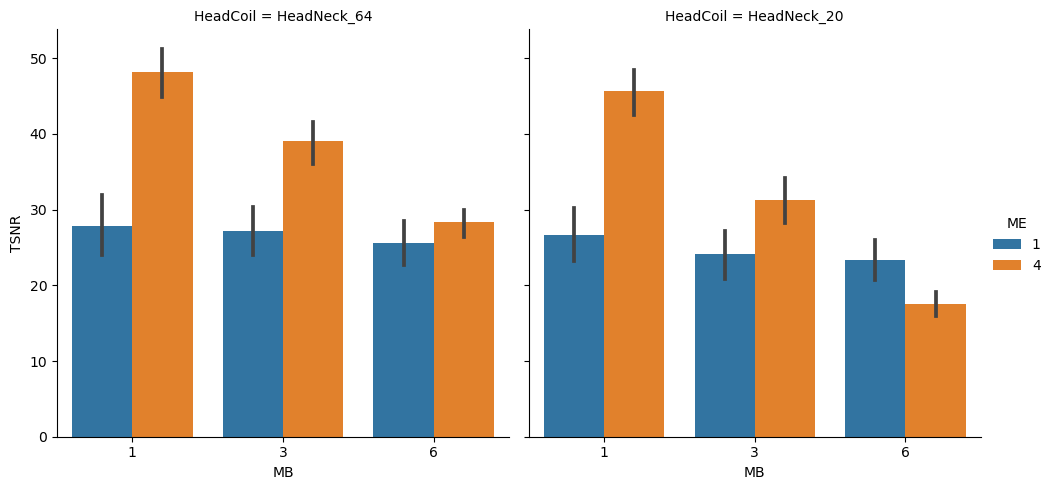

RVS
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 108     Method:             REML     
No. Groups:       18      Scale:              6.3674   
Min. group size:  6       Log-Likelihood:     -281.7757
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   28.992    1.434  20.223 0.000 26.182 31.802
MB          -0.048    0.230  -0.207 0.836 -0.498  0.403
ME           4.609    0.308  14.941 0.000  4.004  5.214
MB:ME       -0.792    0.079 -10.047 0.000 -0.946 -0.637
Group Var   22.436    3.492                            
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              5.5351   
Min. group size:  5       Log-Likelihood:     -219.1703
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   28.709    1.239  23.171 0.000 26.281 31.138
MB          -0.250    0.238  -1.047 0.295 -0.717  0.218
ME           4.516    0.321  14.076 0.000  3.887  5.145
MB:ME       -1.158    0.081 -14.263 0.000 -1.317 -0.999
Group Var    9.630    1.858                            
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       TSNR     
No. Observations:       196           Method:                   REML     
No. Groups:             33            Scale:                    5.9964   
Min. group size:        5             Log-Likelihood:           -502.3034
Max. group size:        6             Converged:                Yes      
Mean group size:        5.9                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     28.712    1.442  19.917 0.000 25.887 31.538
HeadCoil[T.HeadNeck_64]        0.280    1.940   0.144 0.885 -3.524  4.083
MB                            -0.250    0.248  -1.009 0.313 -0.737  0.236
MB:HeadCoil[T.HeadNeck_64]     0.203    0.334   0.608 0.543 -0.451  0.857
ME                             4.516    0.334  13.522 0.000  3.861  5.170
ME:HeadCoil[T.HeadNeck_64]     0.093    0.448   0.208 0.835 -0.786  0.972
MB:ME                         -1.158    0.085 -13.701 0.000 -1.323 -0.992
MB:ME:HeadCoil[T.HeadNeck_64]  0.366    0.114   3.215 0.001  0.143  0.590
Group Var                     16.656    2.004                            
=========================================================================

"""

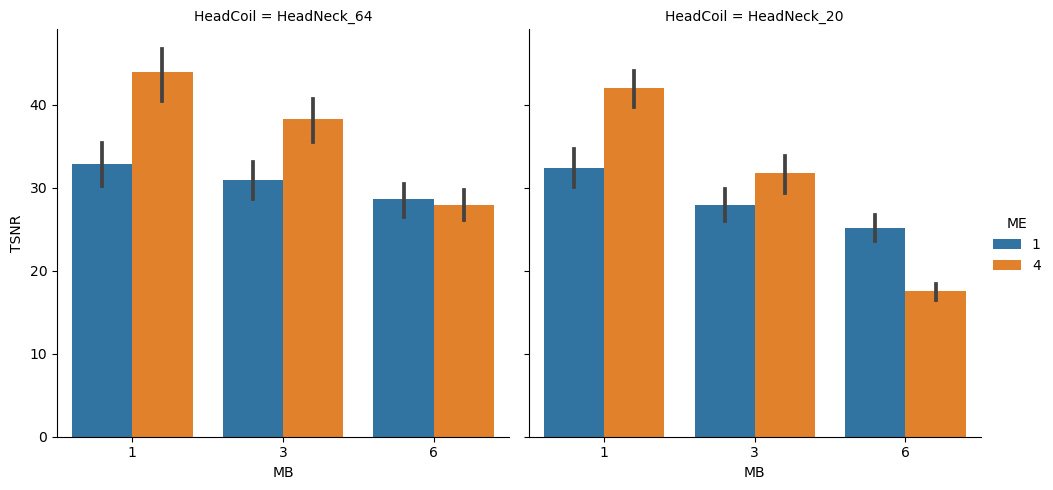

LVS
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 108     Method:             REML     
No. Groups:       18      Scale:              8.9760   
Min. group size:  6       Log-Likelihood:     -293.1327
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    24.654    1.383 17.821 0.000 21.943 27.366
MB            0.297    0.273  1.089 0.276 -0.238  0.831
ME            5.413    0.366 14.780 0.000  4.696  6.131
MB:ME        -0.907    0.094 -9.701 0.000 -1.091 -0.724
Group Var    13.926    1.930                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              9.1670   
Min. group size:  5       Log-Likelihood:     -239.8738
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   22.082    1.570  14.067 0.000 19.005 25.158
MB           0.467    0.307   1.522 0.128 -0.135  1.068
ME           6.015    0.413  14.569 0.000  5.206  6.824
MB:ME       -1.339    0.104 -12.819 0.000 -1.544 -1.135
Group Var   14.775    2.229                            
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       TSNR     
No. Observations:       196           Method:                   REML     
No. Groups:             33            Scale:                    9.0613   
Min. group size:        5             Log-Likelihood:           -533.0167
Max. group size:        6             Converged:                Yes      
Mean group size:        5.9                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     22.081    1.554  14.207 0.000 19.035 25.128
HeadCoil[T.HeadNeck_64]        2.573    2.088   1.232 0.218 -1.521  6.666
MB                             0.467    0.305   1.531 0.126 -0.131  1.065
MB:HeadCoil[T.HeadNeck_64]    -0.170    0.410  -0.415 0.678 -0.974  0.634
ME                             6.015    0.410  14.654 0.000  5.210  6.819
ME:HeadCoil[T.HeadNeck_64]    -0.601    0.551  -1.091 0.275 -1.682  0.479
MB:ME                         -1.339    0.104 -12.893 0.000 -1.543 -1.136
MB:ME:HeadCoil[T.HeadNeck_64]  0.432    0.140   3.084 0.002  0.157  0.707
Group Var                     14.309    1.460                            
=========================================================================

"""

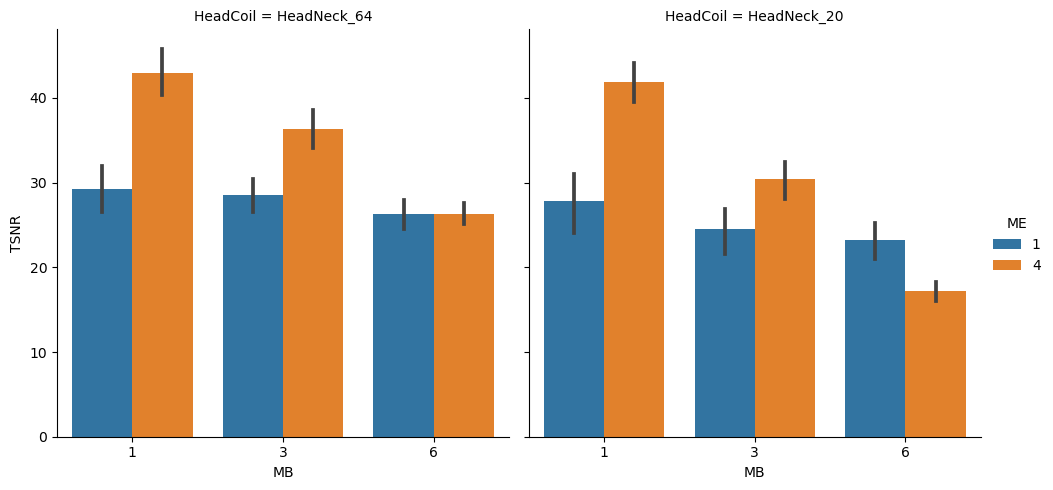

vmPFC
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 108     Method:             REML     
No. Groups:       18      Scale:              41.1463  
Min. group size:  6       Log-Likelihood:     -366.5224
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    33.730    2.614 12.902 0.000 28.606 38.854
MB           -0.008    0.584 -0.014 0.989 -1.152  1.136
ME            4.767    0.784  6.079 0.000  3.230  6.304
MB:ME        -0.468    0.200 -2.335 0.020 -0.860 -0.075
Group Var    28.940    2.093                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              16.5019  
Min. group size:  5       Log-Likelihood:     -267.3823
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    30.556    2.326 13.138 0.000 25.998 35.114
MB           -0.689    0.412 -1.673 0.094 -1.496  0.118
ME            3.322    0.554  5.997 0.000  2.237  4.408
MB:ME        -0.435    0.140 -3.104 0.002 -0.710 -0.160
Group Var    41.183    4.484                           
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM      Dependent Variable:      TSNR     
No. Observations:        196          Method:                  REML     
No. Groups:              33           Scale:                   30.1584  
Min. group size:         5            Log-Likelihood:          -641.5755
Max. group size:         6            Converged:               Yes      
Mean group size:         5.9                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     30.553    2.675 11.420 0.000 25.309 35.797
HeadCoil[T.HeadNeck_64]        3.177    3.592  0.885 0.376 -3.862 10.217
MB                            -0.689    0.557 -1.239 0.215 -1.780  0.401
MB:HeadCoil[T.HeadNeck_64]     0.681    0.748  0.911 0.362 -0.785  2.148
ME                             3.328    0.749  4.445 0.000  1.860  4.795
ME:HeadCoil[T.HeadNeck_64]     1.439    1.006  1.431 0.152 -0.532  3.410
MB:ME                         -0.435    0.189 -2.297 0.022 -0.807 -0.064
MB:ME:HeadCoil[T.HeadNeck_64] -0.032    0.256 -0.126 0.899 -0.533  0.469
Group Var                     34.412    1.999                           
========================================================================

"""

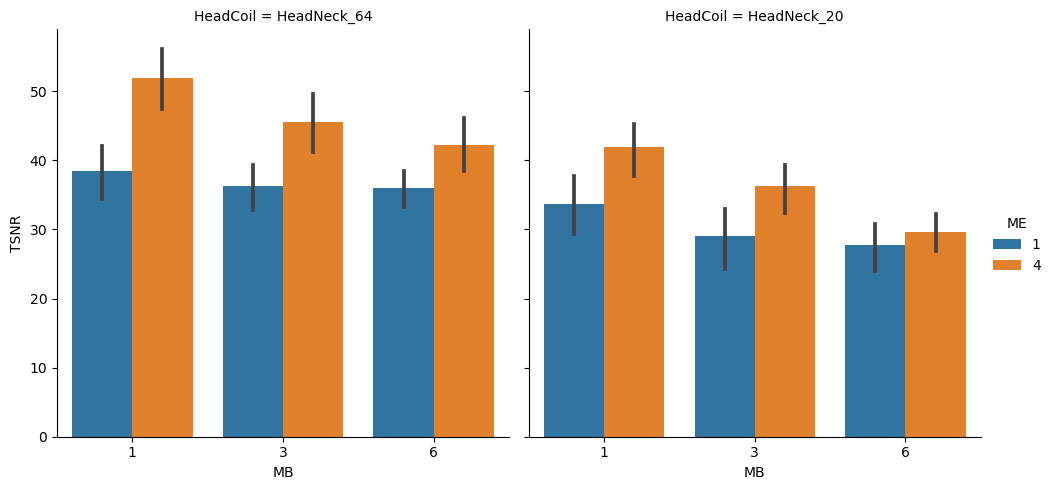

FFA
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 108     Method:             REML     
No. Groups:       18      Scale:              47.2281  
Min. group size:  6       Log-Likelihood:     -375.5964
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    36.968    2.901 12.741 0.000 31.281 42.654
MB            0.277    0.626  0.442 0.658 -0.949  1.503
ME            4.865    0.840  5.790 0.000  3.218  6.511
MB:ME        -0.698    0.215 -3.251 0.001 -1.118 -0.277
Group Var    43.543    2.806                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              14.8412  
Min. group size:  5       Log-Likelihood:     -259.0220
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    33.270    1.933 17.214 0.000 29.482 37.059
MB           -0.424    0.390 -1.086 0.277 -1.189  0.341
ME            4.990    0.525  9.500 0.000  3.961  6.020
MB:ME        -0.993    0.133 -7.467 0.000 -1.253 -0.732
Group Var    20.114    2.431                           
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM      Dependent Variable:      TSNR     
No. Observations:        196          Method:                  REML     
No. Groups:              33           Scale:                   32.7824  
Min. group size:         5            Log-Likelihood:          -647.7223
Max. group size:         6            Converged:               Yes      
Mean group size:         5.9                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     33.286    2.736 12.167 0.000 27.924 38.648
HeadCoil[T.HeadNeck_64]        3.682    3.671  1.003 0.316 -3.514 10.878
MB                            -0.427    0.580 -0.736 0.462 -1.564  0.710
MB:HeadCoil[T.HeadNeck_64]     0.704    0.780  0.902 0.367 -0.825  2.232
ME                             4.986    0.781  6.387 0.000  3.456  6.516
ME:HeadCoil[T.HeadNeck_64]    -0.121    1.048 -0.116 0.908 -2.176  1.934
MB:ME                         -0.992    0.198 -5.021 0.000 -1.379 -0.605
MB:ME:HeadCoil[T.HeadNeck_64]  0.294    0.266  1.105 0.269 -0.228  0.817
Group Var                     32.957    1.866                           
========================================================================

"""

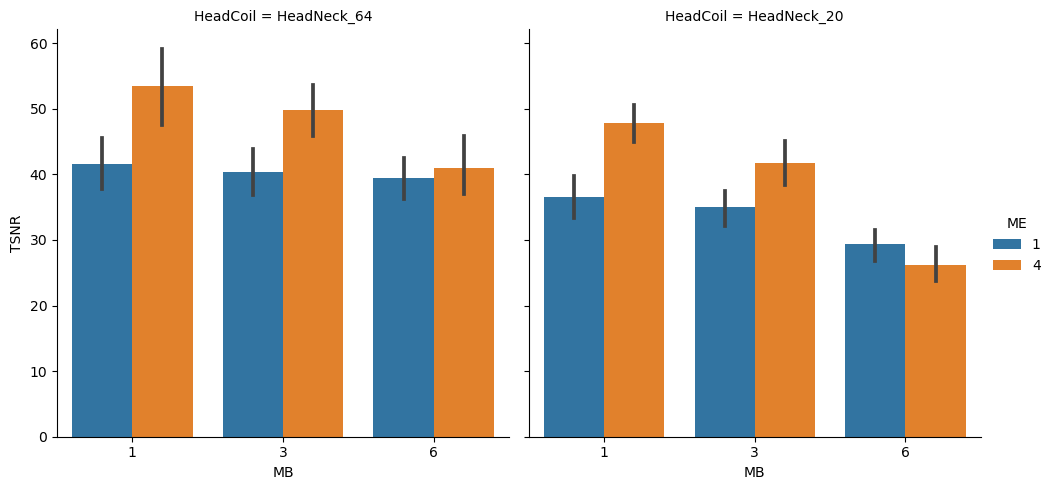

sCerb
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 108     Method:             REML     
No. Groups:       18      Scale:              12.0120  
Min. group size:  6       Log-Likelihood:     -306.9465
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    40.793    1.547 26.362 0.000 37.760 43.826
MB           -0.075    0.315 -0.239 0.811 -0.694  0.543
ME            4.426    0.424 10.447 0.000  3.596  5.257
MB:ME        -0.746    0.108 -6.898 0.000 -0.958 -0.534
Group Var    15.634    1.908                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              9.0010   
Min. group size:  5       Log-Likelihood:     -236.6892
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   40.080    1.451  27.615 0.000 37.235 42.925
MB          -0.568    0.304  -1.869 0.062 -1.164  0.028
ME           5.022    0.409  12.278 0.000  4.220  5.824
MB:ME       -1.187    0.104 -11.463 0.000 -1.390 -0.984
Group Var    9.821    1.562                            
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       TSNR     
No. Observations:       196           Method:                   REML     
No. Groups:             33            Scale:                    10.6692  
Min. group size:        5             Log-Likelihood:           -544.8006
Max. group size:        6             Converged:                Yes      
Mean group size:        5.9                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     40.082    1.609  24.914 0.000 36.929 43.235
HeadCoil[T.HeadNeck_64]        0.711    2.160   0.329 0.742 -3.523  4.945
MB                            -0.569    0.331  -1.718 0.086 -1.218  0.080
MB:HeadCoil[T.HeadNeck_64]     0.493    0.445   1.109 0.268 -0.379  1.365
ME                             5.022    0.445  11.276 0.000  4.149  5.894
ME:HeadCoil[T.HeadNeck_64]    -0.595    0.598  -0.995 0.320 -1.768  0.577
MB:ME                         -1.187    0.113 -10.528 0.000 -1.408 -0.966
MB:ME:HeadCoil[T.HeadNeck_64]  0.440    0.152   2.897 0.004  0.142  0.738
Group Var                     13.010    1.258                            
=========================================================================

"""

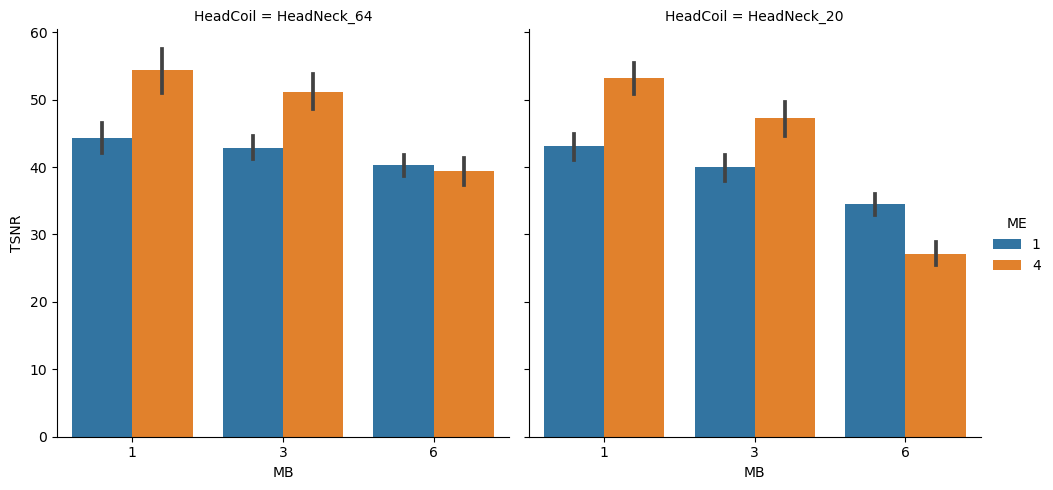

iCerb
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 108     Method:             REML     
No. Groups:       18      Scale:              9.7611   
Min. group size:  6       Log-Likelihood:     -300.9693
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    38.888    1.598 24.343 0.000 35.757 42.019
MB            0.176    0.284  0.619 0.536 -0.381  0.733
ME            4.815    0.382 12.608 0.000  4.067  5.564
MB:ME        -0.666    0.098 -6.828 0.000 -0.857 -0.475
Group Var    23.618    3.030                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              33.8786  
Min. group size:  5       Log-Likelihood:     -295.3979
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    33.206    3.079 10.784 0.000 27.171 39.241
MB            0.002    0.590  0.003 0.998 -1.155  1.158
ME            4.723    0.794  5.951 0.000  3.167  6.279
MB:ME        -1.223    0.201 -6.090 0.000 -1.617 -0.830
Group Var    60.226    4.686                           
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM      Dependent Variable:      TSNR     
No. Observations:        196          Method:                  REML     
No. Groups:              33           Scale:                   20.5170  
Min. group size:         5            Log-Likelihood:          -612.8708
Max. group size:         6            Converged:               Yes      
Mean group size:         5.9                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     33.205    2.447 13.570 0.000 28.410 38.001
HeadCoil[T.HeadNeck_64]        5.683    3.290  1.727 0.084 -0.766 12.131
MB                             0.002    0.459  0.004 0.997 -0.898  0.902
MB:HeadCoil[T.HeadNeck_64]     0.174    0.617  0.282 0.778 -1.035  1.384
ME                             4.723    0.618  7.647 0.000  3.513  5.934
ME:HeadCoil[T.HeadNeck_64]     0.092    0.830  0.111 0.912 -1.534  1.718
MB:ME                         -1.223    0.156 -7.826 0.000 -1.530 -0.917
MB:ME:HeadCoil[T.HeadNeck_64]  0.557    0.211  2.644 0.008  0.144  0.970
Group Var                     40.148    2.674                           
========================================================================

"""

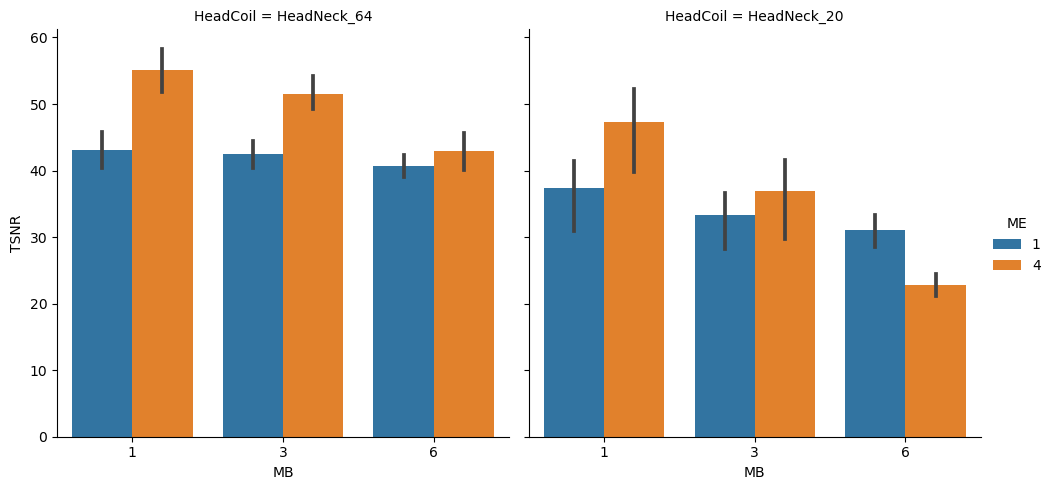

Motor
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 108     Method:             REML     
No. Groups:       18      Scale:              44.7658  
Min. group size:  6       Log-Likelihood:     -367.5444
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    45.760    2.594 17.641 0.000 40.676 50.844
MB            0.549    0.609  0.902 0.367 -0.644  1.743
ME            3.152    0.818  3.853 0.000  1.548  4.755
MB:ME        -0.682    0.209 -3.265 0.001 -1.091 -0.273
Group Var    18.762    1.470                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              11.2719  
Min. group size:  5       Log-Likelihood:     -247.5008
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    42.736    1.686 25.348 0.000 39.431 46.040
MB           -0.526    0.340 -1.546 0.122 -1.193  0.141
ME            3.436    0.458  7.505 0.000  2.538  4.333
MB:ME        -0.946    0.116 -8.161 0.000 -1.173 -0.718
Group Var    15.357    2.133                           
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM      Dependent Variable:      TSNR     
No. Observations:        196          Method:                  REML     
No. Groups:              33           Scale:                   29.8307  
Min. group size:         5            Log-Likelihood:          -631.7894
Max. group size:         6            Converged:               Yes      
Mean group size:         5.9                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     42.784    2.440 17.537 0.000 38.003 47.566
HeadCoil[T.HeadNeck_64]        2.976    3.270  0.910 0.363 -3.434  9.386
MB                            -0.535    0.553 -0.966 0.334 -1.619  0.550
MB:HeadCoil[T.HeadNeck_64]     1.084    0.744  1.457 0.145 -0.374  2.542
ME                             3.419    0.744  4.592 0.000  1.960  4.878
ME:HeadCoil[T.HeadNeck_64]    -0.267    1.000 -0.267 0.789 -2.227  1.693
MB:ME                         -0.943    0.188 -5.005 0.000 -1.312 -0.574
MB:ME:HeadCoil[T.HeadNeck_64]  0.261    0.254  1.027 0.304 -0.237  0.759
Group Var                     17.172    1.130                           
========================================================================

"""

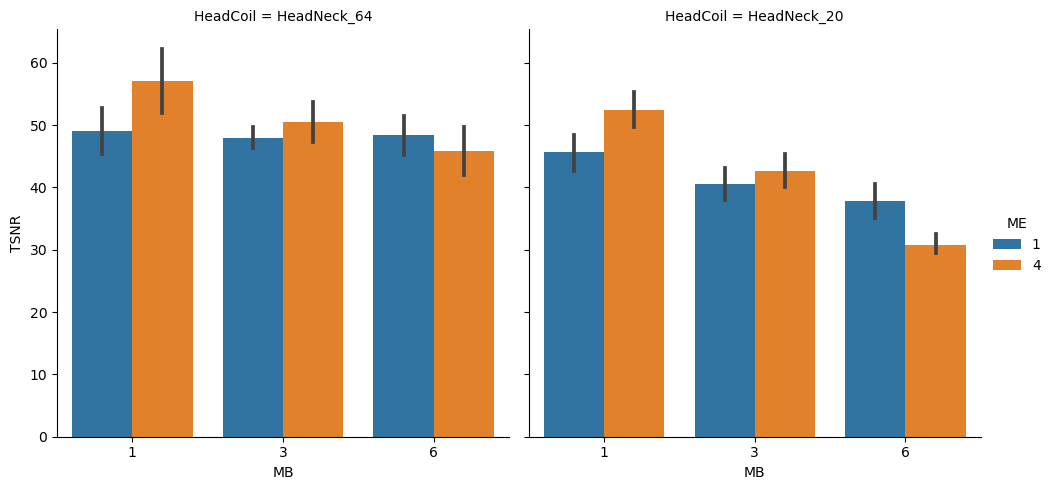

In [7]:
import matplotlib.pyplot as plt
#import statsmodels.api as sm
import statsmodels.formula.api as smf

#df=pd.read_csv("../derivatives/TSNRinfo.tsv",sep='\t')
display(df2)
for region in df2['Region'].unique():
    print(region)
    plt_df=df2[df2['Region']==region]
    for HC in plt_df['HeadCoil'].unique():
        mod_df = plt_df[plt_df['HeadCoil'] == HC]
        print(HC)
        res=smf.mixedlm('TSNR ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
        display(res.summary())
    res=smf.mixedlm('TSNR ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
    display(res.summary())
    sns.catplot(x='MB',y='TSNR',hue='ME',col='HeadCoil',data=plt_df,kind='bar')
    plt.savefig("../derivatives/figures/TSNR_%s_plot.svg" %(region))
    plt.show()

In [8]:
t_dir='../derivatives/tsnr/'
mb1me1_list=[t_dir+f for f in os.listdir(t_dir) if 'mb1me1_tsnr.nii.gz' in f]
mb3me1_list=[t_dir+f for f in os.listdir(t_dir) if 'mb3me1_tsnr.nii.gz' in f]
mb6me1_list=[t_dir+f for f in os.listdir(t_dir) if 'mb6me1_tsnr.nii.gz' in f]
mb1me4_list=[t_dir+f for f in os.listdir(t_dir) if 'mb1me4_tsnr.nii.gz' in f]
mb3me4_list=[t_dir+f for f in os.listdir(t_dir) if 'mb3me4_tsnr.nii.gz' in f]
mb6me4_list=[t_dir+f for f in os.listdir(t_dir) if 'mb6me4_tsnr.nii.gz' in f]

In [9]:
import nibabel as nib
img=mean_img(mb1me4_list)
nib.save(img,'../derivatives/tsnr/group_mb1me4.nii.gz')

In [ ]:
root='../derivatives/fmriprep/'
allfiles = [os.path.join(folder, f) for folder, dirs, files in os.walk(root) for f in files if f.endswith('-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')]
mean_anat=mean_img(allfiles)

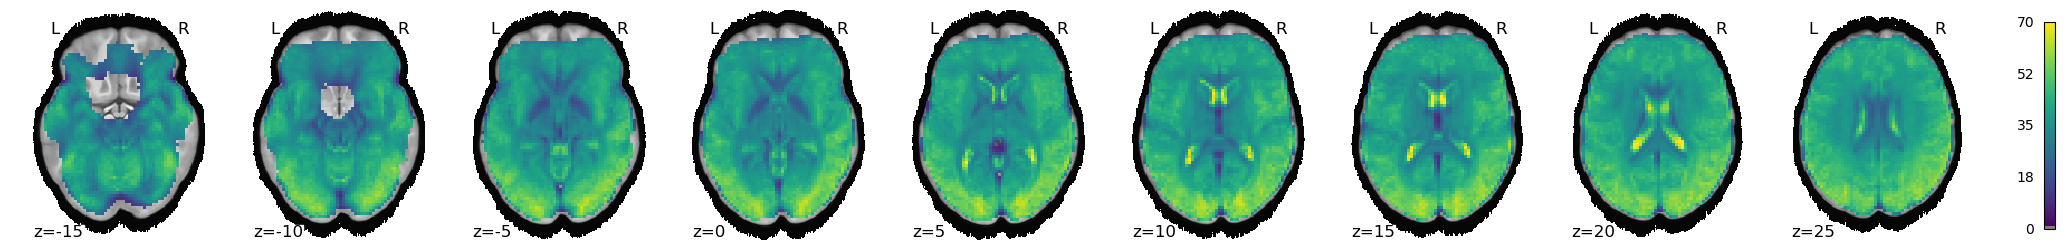

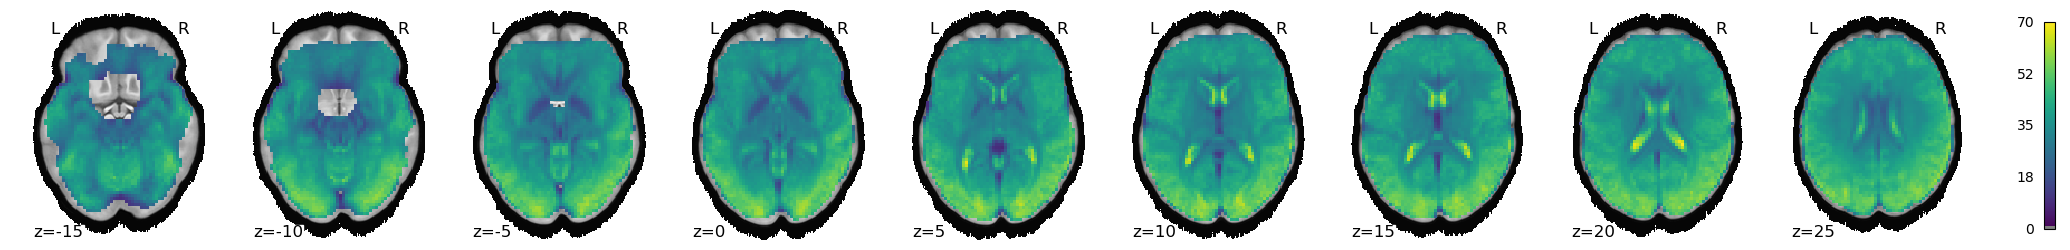

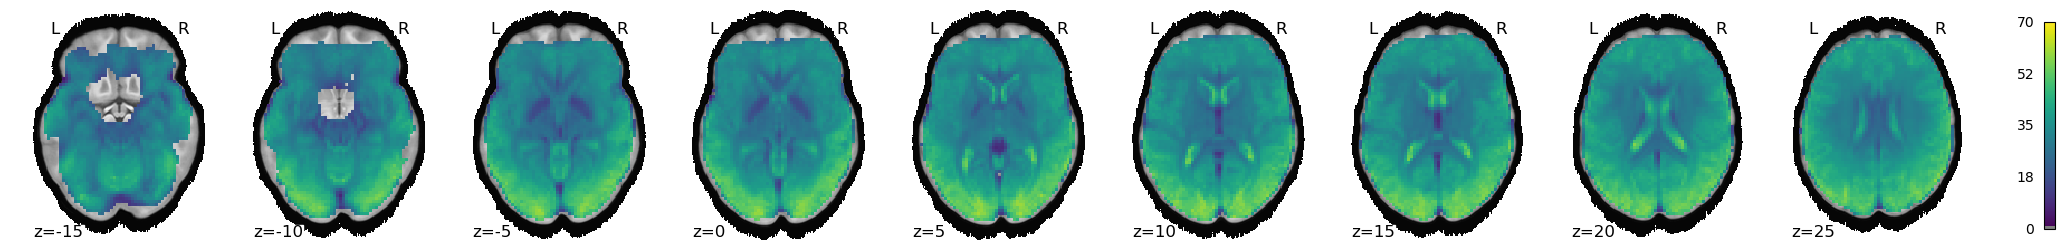

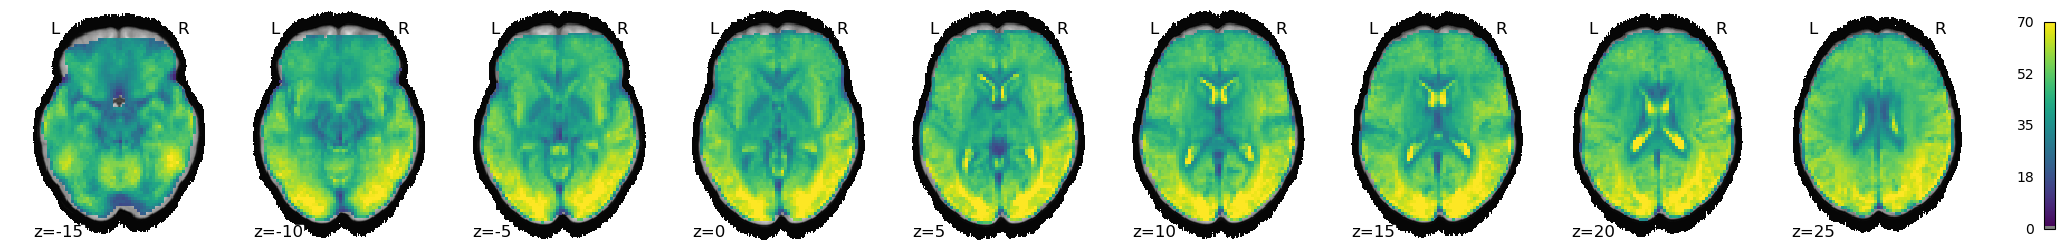

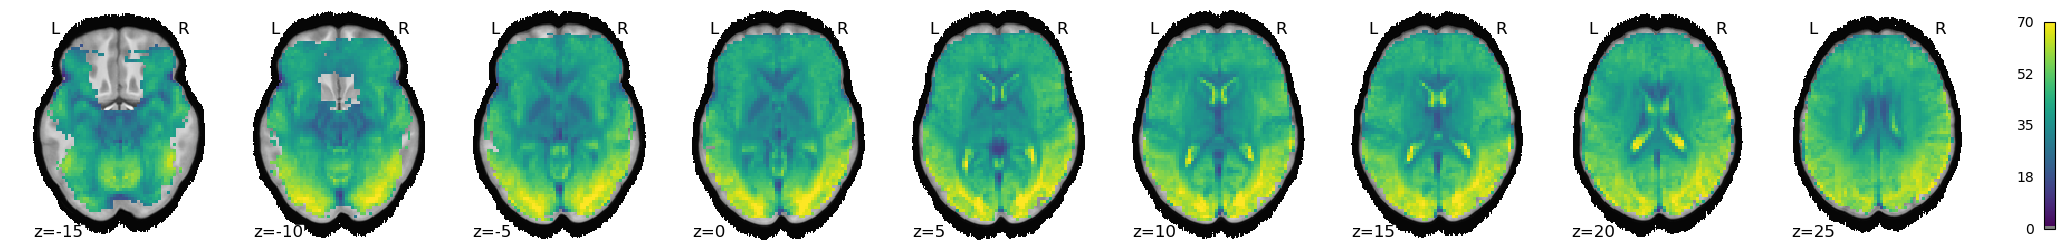

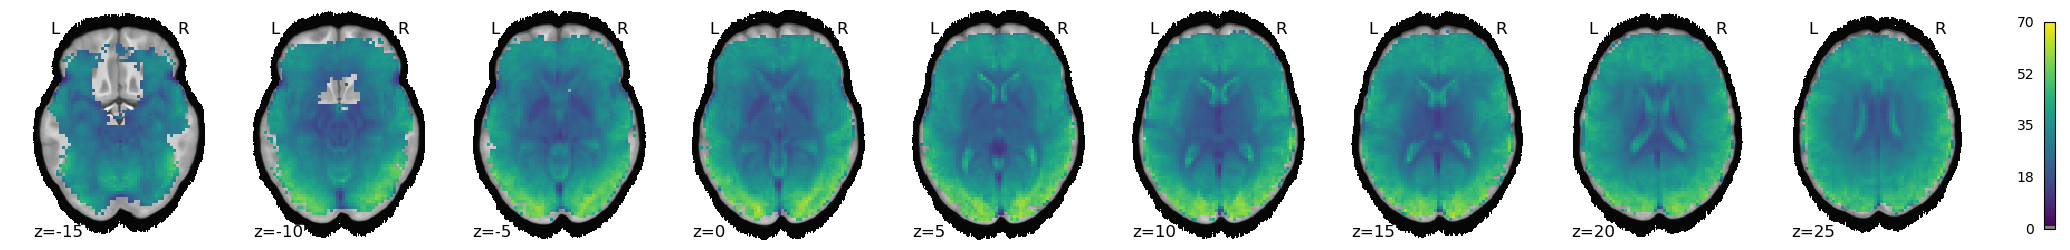

In [32]:
vmax=70
vmin=0
thresh=1
bg_img=mean_anat

img=mean_img(mb1me1_list)
#plotting.plot_stat_map(img,draw_cross=False,cmap='viridis',display_mode='z',
#                       cut_coords=(-20,-10,0,10,20,30),vmax=vmax)
plotting.plot_img(img,draw_cross=False,cmap='viridis',display_mode='z',vmin=vmin,bg_img=bg_img,threshold=thresh,
                       cut_coords=(-15,-10,-5,0,5,10,15,20,25),vmax=vmax,colorbar=True)
plt.savefig('../derivatives/figures/assets/TSNR_axial-mb1me1.svg')
plt.show()

img=mean_img(mb3me1_list)
#plotting.plot_stat_map(img,draw_cross=False,cmap='viridis',display_mode='z',
#                       cut_coords=(-20,-10,0,10,20,30),vmax=vmax)
plotting.plot_img(img,draw_cross=False,cmap='viridis',display_mode='z',vmin=vmin,bg_img=bg_img,threshold=thresh,
                       cut_coords=(-15,-10,-5,0,5,10,15,20,25),vmax=vmax,colorbar=True)
plt.savefig('../derivatives/figures/assets/TSNR_axial-mb3me1.svg')
plt.show()

img=mean_img(mb6me1_list)
#plotting.plot_stat_map(img,draw_cross=False,cmap='viridis',display_mode='z',
#                       cut_coords=(-20,-10,0,10,20,30),vmax=vmax)
plotting.plot_img(img,draw_cross=False,cmap='viridis',display_mode='z',vmin=vmin,bg_img=bg_img,threshold=thresh,
                       cut_coords=(-15,-10,-5,0,5,10,15,20,25),vmax=vmax,colorbar=True)
plt.savefig('../derivatives/figures/assets/TSNR_axial-mb6me1.svg')
plt.show()

img=mean_img(mb1me4_list)
#plotting.plot_stat_map(img,draw_cross=False,cmap='viridis',display_mode='z',
#                       cut_coords=(-20,-10,0,10,20,30),vmax=vmax)
plotting.plot_img(img,draw_cross=False,cmap='viridis',display_mode='z',vmin=vmin,bg_img=bg_img,threshold=thresh,
                       cut_coords=(-15,-10,-5,0,5,10,15,20,25),vmax=vmax,colorbar=True)
plt.savefig('../derivatives/figures/assets/TSNR_axial-mb1me4.svg')
plt.show()

img=mean_img(mb3me4_list)
#plotting.plot_stat_map(img,draw_cross=False,cmap='viridis',display_mode='z',
#                       cut_coords=(-20,-10,0,10,20,30),vmax=vmax)
plotting.plot_img(img,draw_cross=False,cmap='viridis',display_mode='z',vmin=vmin,bg_img=bg_img,threshold=thresh,
                       cut_coords=(-15,-10,-5,0,5,10,15,20,25),vmax=vmax,colorbar=True)
plt.savefig('../derivatives/figures/assets/TSNR_axial-mb3me4.svg')
plt.show()

img=mean_img(mb6me4_list)
#plotting.plot_stat_map(img,draw_cross=False,cmap='viridis',display_mode='z',
#                       cut_coords=(-20,-10,0,10,20,30),vmax=vmax)
plotting.plot_img(img,draw_cross=False,cmap='viridis',display_mode='z',vmin=vmin,bg_img=bg_img,threshold=thresh,
                       cut_coords=(-15,-10,-5,0,5,10,15,20,25),vmax=vmax,colorbar=True)
plt.savefig('../derivatives/figures/assets/TSNR_axial-mb6me4.svg')
plt.show()

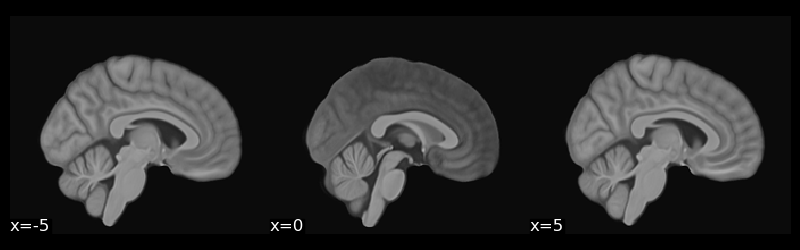

In [51]:
ax=plotting.plot_anat(mean_anat,display_mode='x',cut_coords=(-5,0,5))
ax.draw_cross(cut_coords=(0,0,-15),kwargs={'color':'r'})
plt.show()
